Rewrite of the code associated with the sine wave generator from "A tutorial on training recurrent neural networks, covering BPPT, RTRL, EKF and the 'echo state network' approach" by Herbert Jaeger

In [56]:
#importing libraries....
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import eigs
from matplotlib.animation import FuncAnimation


In [2]:
#things to note

#still need to check if the W_internal is being generated the same way, are you suppossed to get negative values?
#is "tanh" a built in matlab function? is this is whats being used as the reservoir activation function? its inside of feval in matlab
#what is the deal with rows and collumns in matlap, relative to python? Do i need to care, some arrays are transposed in matlab but i dont think i need to
#compare compute_teacher calculation of teachCollectMat, are they equivalent?
#confrim train_Woutput aligns with wiener_hopf.m (it definetly does not)
#does the wiener method also produce a non-zero weight for input-output unit connections? looks like yes, can we just set this to 0 after training without destroying network

#questions for the 26th
#how should i figure out if my sin wave has completed a cycle?
#maybe the other training method is more robust at handling noise? 

#due to decay, the actually valuable signal is quite weak by the end of the sine wave, meaning that we need larger weights to extract our wave
#these massive weights (sometimes millions) blow up any variance to the point where it destroys the signal
#we can counter this by adding more units

#is there a way to avoid the wave just missing 0 and thus not triggering the tap feedback

In [2]:
#just going to have all my input/output pairs up here to keep the rest of the code organized.... 

#regiment1 = off-set square waves
input = np.zeros((150,1))
output = np.zeros((150,1))
input[20:30] = 1
output[30:40] = 0.5
regiment1 = [input,output]

#regiment2 = sine wave from square wave
input = np.zeros((200,1))
input[0] = 1

output = np.zeros((200,1))
wave = np.sin(np.linspace(0,(np.pi * 2),200))

for i in range(200):
    output[i:] = wave[i]

output = output * 0.5

regiment2 = [input,output]

#regiment 3, two sine waves of different periods from a square wave and a context signal
input = np.zeros((350,2))
input[0,1] = 1
input[170,1] = 2

input[0,0] = 1
input[170,0] = 1


output=np.zeros((350,1))


wave = np.sin(np.linspace(0,np.pi*2,100))*0.5
wave2 = np.sin(np.linspace(0,np.pi*2,160))*0.5

for i in range(100):
    output[i,0] = wave[i]

for i in range(160):
    output[i+170,0] = wave2[i]

regiment3 = [input,output]


In [64]:
print(regiment3[0])

[[1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 

In [96]:
class ESNN:
    def __init__(self, n_input, n_internal, n_output,spectralRadius=1,inputScaling=1,inputShift=0,outputActivationFunction="tanh",noise_level=0, teacherScaling=1, teacherShift=0,methodWeightCompute="pseudoinverse", connectivityScale = 1, network_type = "plain", time_constant=1, leakage=0):
        import numpy as np

        #initialize hyperparameters
        self.n_input = n_input
        self.n_internal = n_internal
        self.n_output = n_output
        self.n_total = n_input + n_internal + n_output
        #how much are we shifting/scaling the input signal
        self.inputScaling = inputScaling
        self.inputShift = inputShift
        #how much are we shifting/scaling the teacher signal
        self.teacherScaling = teacherScaling
        self.teacherShift = teacherShift
        #spectral radius controls the magnitude of the values in the internal connectivity matrix
        self.spectralRadius = spectralRadius
        self.noise_level = noise_level
        #how are we normalizing outputs to [0,1]
        self.outputActivationFunction = outputActivationFunction
        self.learningMode = "offline_singleTimeSeries"
        #what algorithm are we using to compute the output weights
        self.methodWeightCompute = methodWeightCompute
        self.internalstore = 0
        #are the units in the network leaky or not?
        self.network_type = network_type

        #these are important if leaky
        self.time_constant = time_constant
        self.leakage = leakage 

        #intialize hidden weight matrix density
    
        self.connectivity = min([10/n_internal,1]) * connectivityScale

        #generate input weight matrix
        self.W_input = 2 * np.random.rand(n_internal, n_input) - 1 
        #generate internal weight matrix
        self.W_internal = self.gen_W_internal(self.n_internal, self.connectivity)
        #generate output weights, original code included input-output connections, lets skip those
        self.W_output = 2 * np.random.rand(n_output, n_internal) - 1 
        #these are the "feedback" weights from output to internal, setting to zero for now, only keeping in code to maintain similar structure as original
        self.W_feedback = np.zeros((n_internal, n_output))
        #self.W_feedback = 2 * np.random.rand(n_internal, n_output) - 1 

        #using this method because I cannot program properly...
        self.statemat = []

    #get this checked next to the matlab code
    #this function creates the random internal weight matrix
    def gen_W_internal(self, n_internal, connectivity):
        #import libraries (get this fixed)
        from scipy.sparse.linalg import eigs
        import scipy.sparse as sparse
        #generate randomly distributed sparese n_internal x n_internal matrix 
        W_internal = sparse.rand(n_internal, n_internal,density=connectivity,format="coo")
        #find the maximum eigenvalue of said matrix
        maxval = max(abs(eigs(W_internal, return_eigenvectors=False,k=1,which="LM")))
        #transform into an array form (some weird scipy thing i guess)
        W_internal = W_internal.toarray()

        #center mean of entries at 0, ensure we have negative values to yield echoes
        W_internal = np.where(W_internal>0, W_internal - 0.5, W_internal)

        #normalize the weight matrix by dividing by the largest eigenvalue, then multiple by the selected spectral radius
        return np.array(self.spectralRadius * W_internal / maxval)
    
    #inputSequence is nTrainingPoints x nInputDim
    #outputSequence is nTrainingPoints x nOutputDim
    #nForgetPoints is the number of initial data points we wash out to avoid initial transients
    def compute_statematrix(self,inputSequence,outputSequence=[],nForgetPoints=0):  
        import numpy as np
        #if there is no supplied output sequence, the ESNN is assumed to be in testing, as opposed to training
        if len(outputSequence) == 0:
            teacherForcing = 0
            nDataPoints = len(inputSequence[:,0])
        else:
            teacherForcing = 1
            nDataPoints = len(inputSequence[:,0])


        #define the "state collection matrix", contains all activity of the input as well as internal units
        if nForgetPoints > 0:
            stateCollectMat = np.zeros((nDataPoints - nForgetPoints, self.n_internal))
        else:
            stateCollectMat = np.zeros((nDataPoints, self.n_internal))

        ### I am ignoring the section of code about giving the network a starting state before input

        #matrices holding the activity of all units and internal units?
        totalstate = np.zeros(self.n_total) #note the units appear in this matrice in order of [internal, input, output], idk why blame jaeger
        internalstate = np.zeros(self.n_internal)

        collectIndex = 0
        for i in range(0,nDataPoints):
            #shift and scale input activation by predefined values
            a_input = inputSequence[i,:] * self.inputScaling + self.inputShift
            #write this input signal into the totalstate matrix
            totalstate[self.n_internal:self.n_input+self.n_internal] = a_input

            #combine all weight matrices into one so matmul works
            W_concatenate = np.concatenate((self.W_internal, self.W_input, self.W_feedback),axis=1)
            #calculate internal state based on activity of all units, sent through a hyperbolic function to keep below 0
            #add uniformly distributed noise
            if self.network_type == "plain":
                internalstate = np.tanh(np.matmul(W_concatenate,  totalstate)) + np.random.uniform(-1,1,self.n_internal) * self.noise_level
            if self.network_type == "leaky":
                #grab the activity of the internal units last time step
                previous_internalstate = totalstate[0:self.n_internal] 
                #first calculate how much the previous state has decayed, then add the activity resulting from all inputs
                internalstate = (1 - self.leakage * self.time_constant) * previous_internalstate + self.time_constant * np.tanh(np.matmul(W_concatenate,  totalstate))
                #add noise 
                internalstate = internalstate + np.random.uniform(-1,1,self.n_internal) * self.noise_level

            #if we are forcing output, the output is set as the predefined signal
            #otherwise we calculate it based on internal unit activity
            if teacherForcing == 1: 
                netOut = self.teacherScaling * outputSequence[i,:] + self.teacherShift
            else:
                netOut = np.tanh(np.matmul(self.W_output, internalstate ))

            #put all the unit activities together in a array of form [internal units, input units, output units]
            totalstate = np.concatenate((internalstate, a_input, netOut))                

            #put all of our input and internal activities into a matrix that contains all their behaviour over time
            #we are ignoring the first nForgetPoints entries
            if i >= nForgetPoints:
                stateCollectMat[collectIndex,:] = internalstate
                collectIndex += 1
            
            if len(self.statemat)==0:
                self.statemat = stateCollectMat

        return stateCollectMat
    
    
    #this function takes in a input and desired produced output, as well as the number of initial activity points that should be ignored while calculating the statematrix (these may be a problem)
    def train(self, trainInput, trainOuput, nForgetPoints):
        
        #allowing myself to add other training modes later if i want
        if self.learningMode == "offline_singleTimeSeries":
            #computes the activity of the internal units due to input and feedback activity
            stateCollection = self.compute_statematrix(inputSequence=trainInput, outputSequence=trainOuput,nForgetPoints=nForgetPoints)
            #calculates what the input to the output units should be, "unsquashes" them
            teacherCollection = self.compute_teacher(outputSequence=trainOuput, nForgetPoints=nForgetPoints)
            #actually trains the output weights 
            self.W_output = self.train_Woutput(stateCollection,teacherCollection)


        return None

    #scales, shifts, and applies the inverse output activation function on the expected teacher
    def compute_teacher(self,outputSequence,nForgetPoints):
        import numpy as np

        nOutputPoints = len(outputSequence[:,0])
        teachCollectMat = np.zeros((nOutputPoints-max([0,nForgetPoints]),self.n_output))

        #remove the first nForgetPoints from the output sequence
        if nForgetPoints > 0:
            outputSequence = outputSequence[nForgetPoints:,:]

        #update the number of point (I'm just doing what Jaeger did dont blame me)
        nOutputPoints = len(outputSequence[:,0])

        #compare this to matlab code as well, no idea whats happening
        #i think this is just shifting/scaling the output, whatever that means
        teachCollectMat = self.teacherScaling * outputSequence + self.teacherShift

        #calculate what the corresponding input to the output units should be, essentially undo tanh squashing
        teachCollectMat=np.arctanh(teachCollectMat)

        return teachCollectMat
    
    #this function actually calculates the new output weights
    def train_Woutput(self, stateCollectMat, teacherCollectMat):
        import numpy
        
        #allowing the training method to be specified in case I want to add more later
        #i have no clue wtf the wiener-hopf method is, this is my best attempt to replicate the matlab code exactly
        if self.methodWeightCompute == "wiener_hopf":
            runlength = len(stateCollectMat[:,0])
            covMat = np.matmul(np.transpose(stateCollectMat),stateCollectMat)/runlength
            pVec = np.matmul(np.transpose(stateCollectMat), teacherCollectMat)/runlength
            outputWeights = np.matmul(np.linalg.inv(covMat),pVec)

        #this is another training method ripped from the matlab code
        if self.methodWeightCompute == "pseudoinverse":
            stateCollectMat = np.linalg.pinv(stateCollectMat)
            outputWeights = np.matmul(stateCollectMat,teacherCollectMat)
        
        else:
            print("invalid methodWeightCompute value")


        return outputWeights
    
    #this function will determine how closely the network can replicate the desired output
    def evaluate(self, inputSequence, outputSequence,nForgetPoints=0):
        import numpy
        import matplotlib.pyplot as plt
        #generate the expected output of the network
        #determine activity of internal and input units
        a_internal = self.compute_statematrix(inputSequence=inputSequence, outputSequence=outputSequence, nForgetPoints=nForgetPoints)
        #matrix multiply with trained output weights
        predictedTrainOutput = np.concatenate(np.tanh(np.matmul(a_internal,self.W_output)))

        #remove the shifting and scaling (probably useless)
        predictedTrainOutput = (predictedTrainOutput - self.teacherShift)/self.teacherScaling

        meanerror, error = self.compute_error(predictedTrainOutput,outputSequence,nForgetPoints)

        print("mean square error=", meanerror, "error=", error)

        #graph our expected and observed signals
        y = len(predictedTrainOutput)

        plt.plot(predictedTrainOutput, label="Observed Signal", color="red",alpha = 0.5)
        plt.plot(outputSequence,label="Training Data",color="blue", alpha=0.5)
        plt.plot(inputSequence,label="Input Sequence", color="green",alpha=0.5)
        plt.legend()

        return None 

    #this function may not work for outputs containing for than one unit (hopefully not a problem)
    def compute_error(self, observed, expected, nForgetPoints):

        #how long is our real output
        nEstimatePoints = len(observed)

        nForgetPoints = len(expected[:,0]) - nEstimatePoints

        expected = expected[nForgetPoints:]

        #three lines above this only relavant if nForgetPoints>0, not sure if this will ever happen

        meanerror = np.sum(np.square(expected - observed)) / nEstimatePoints 
        error = (np.sqrt(meanerror/np.var(expected)))
        
        return meanerror, error 
    
    def display_units(self):
        fig, axs = plt.subplots(4, 5)
        storage = []
        for i in range(4):
            for j in range(5):
                passing = False
                while passing == False:
                    k = np.random.randint(len(self.statemat[0]))
                    if storage.count(k)==0:
                        storage.append(k)
                        axs[i,j].plot(self.statemat[:,k],color = "darkviolet",alpha=0.5 )
                        passing = True
        
        for ax in axs.flat:
            ax.set(xlabel='time', ylabel='activity')
        for ax in axs.flat:
            ax.label_outer()

        return None

    #going off of the pre-exhisting code from compute_statematrix, we will have the ESNN generate its own input based on when its produced sine wave finishes a cycle
    #will require specially constructed input sequences
    #probably always keep nForgetPoints = 0, i have never tested it so it probably doesn't work, it was in Jaeger's code so I moved it over 
    def live_run(self, input_type, time_points=0):  
        import numpy as np

        #does this network take a context signal to produce its sine wave? type 1 means it does not
        if input_type==1:
            inputSequence  = np.zeros((time_points, 1))
            inputSequence[0] = 1
            #for i in np.arange(0,time_points,200):
                #inputSequence[i] = 1
        
        if input_type==2:
            inputSequence = np.zeros((time_points, 2))
            inputSequence[0,0] = 1
            inputSequence[0,1] = 1 
            
        outputSequence = []
        nForgetPoints = 0
        
        #if there is no supplied output sequence, the ESNN is assumed to be in testing, as opposed to training
        if len(outputSequence) == 0:
            teacherForcing = 0
            nDataPoints = len(inputSequence[:,0])
        else:
            teacherForcing = 1
            nDataPoints = len(inputSequence[:,0])


        #define the "state collection matrix", contains all activity of the input as well as internal units
        if nForgetPoints > 0:
            stateCollectMat = np.zeros((nDataPoints - nForgetPoints, self.n_internal))
        else:
            stateCollectMat = np.zeros((nDataPoints, self.n_internal))

        outputCollectMat = np.zeros((nDataPoints, self.n_output))

        ### I am ignoring the section of code about giving the network a starting state before input

        #matrices holding the activity of all units and internal units?
        totalstate = np.zeros(self.n_total) #note the units appear in this matrice in order of [internal, input, output], idk why blame jaeger
        internalstate = np.zeros(self.n_internal)

        collectIndex = 0
        spike_count = 1

        for i in range(0,nDataPoints):
            #shift and scale input activation by predefined values
            a_input = inputSequence[i,:] * self.inputScaling + self.inputShift
            #write this input signal into the totalstate matrix
            totalstate[self.n_internal:self.n_input+self.n_internal] = a_input

            #combine all weight matrices into one so matmul works
            W_concatenate = np.concatenate((self.W_internal, self.W_input, self.W_feedback),axis=1)
            #calculate internal state based on activity of all units, sent through a hyperbolic function to keep below 0
            #add uniformly distributed noise
            if self.network_type == "plain":
                internalstate = np.tanh(np.matmul(W_concatenate,  totalstate)) + np.random.uniform(-1,1,self.n_internal) * self.noise_level
            if self.network_type == "leaky":
                #grab the activity of the internal units last time step
                previous_internalstate = totalstate[0:self.n_internal] 
                #first calculate how much the previous state has decayed, then add the activity resulting from all inputs
                internalstate = (1 - self.leakage * self.time_constant) * previous_internalstate + self.time_constant * np.tanh(np.matmul(W_concatenate,  totalstate))
                #add noise 
                internalstate = internalstate + np.random.uniform(-1,1,self.n_internal) * self.noise_level

            #if we are forcing output, the output is set as the predefined signal
            #otherwise we calculate it based on internal unit activity
            if teacherForcing == 1: 
                netOut = self.teacherScaling * outputSequence[i,:] + self.teacherShift
            else:
                netOut = np.tanh(np.matmul(np.transpose(self.W_output), internalstate))

            #put all the unit activities together in a array of form [internal units, input units, output units]
            totalstate = np.concatenate((internalstate, a_input, netOut))                

            #put all of our input and internal activities into a matrix that contains all their behaviour over time
            #we are ignoring the first nForgetPoints entries
            if i >= nForgetPoints:
                stateCollectMat[collectIndex,:] = internalstate
                outputCollectMat[collectIndex,:] = netOut
                collectIndex += 1
            
            if input_type == 1: 
                if outputCollectMat[i-1] < 0:
                    if outputCollectMat[i] >= 0:
                        if 1 in outputCollectMat[i-20:i]:
                            pass
                        elif i > 20:
                            try:
                                inputSequence[i+1] = 1
                            except:
                                pass
            
            if input_type == 2:
                if outputCollectMat[i-1] < 0:
                    if outputCollectMat[i] >= 0:
                        if 1 in outputCollectMat[i-20:i,0]:
                            pass
                        elif i > 20:
                            try:
                                inputSequence[i+1,:] = 1
                                spike_count+=1
                                print(spike_count)
                            except:
                                pass
                            if spike_count > 3:
                                inputSequence[i+1,1] = 2

            self.statemat = stateCollectMat
        return stateCollectMat, outputCollectMat, inputSequence

mean square error= 4.668710984497378 error= 17.324301441384996


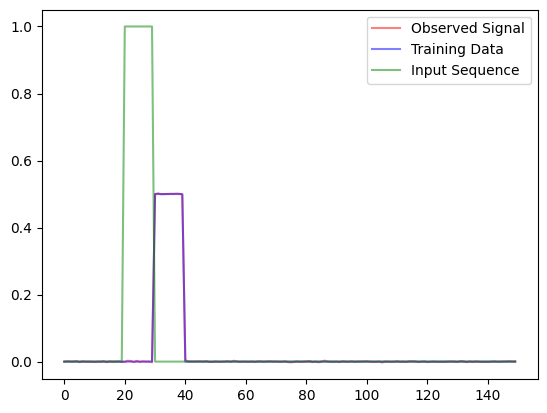

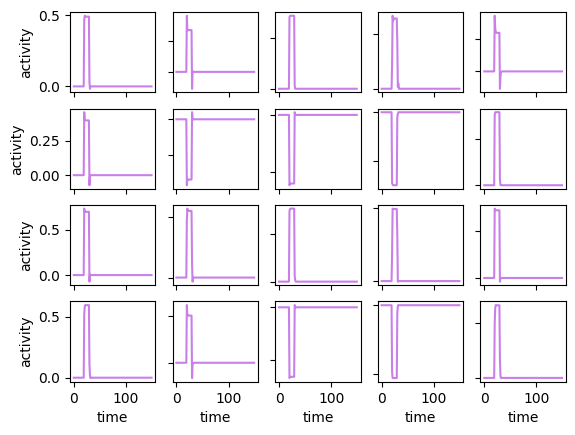

In [37]:
esn = ESNN(n_input=1,n_internal=2000,n_output=1,spectralRadius=0.9,inputScaling=1,noise_level=0.000000001, methodWeightCompute="pseudoinverse", connectivityScale = 1)

esn.train(regiment1[0],regiment1[1],0)
esn.evaluate(regiment1[0],regiment1[1])
esn.display_units(regiment1[0])

mean square error= 49.74999999999987 error= 19.999999999999975


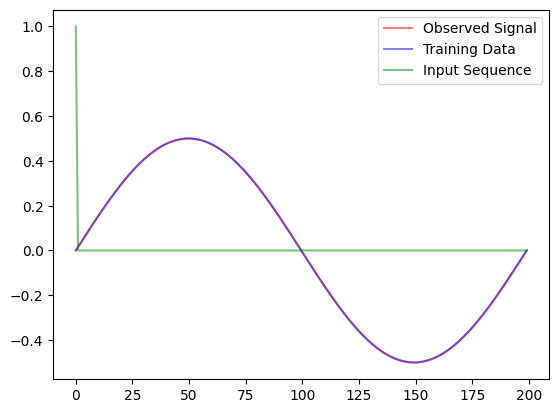

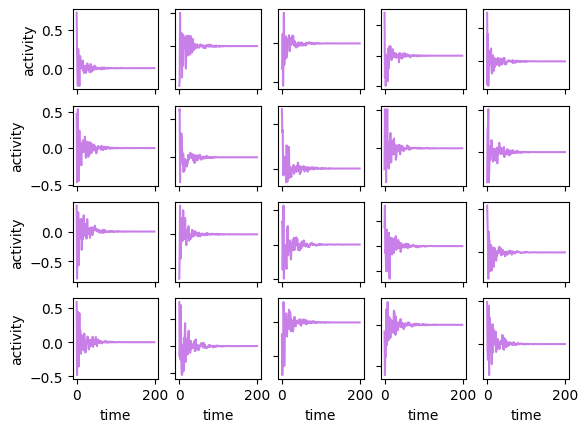

In [44]:
esn2 = ESNN(n_input=1,n_internal=8000,n_output=1,spectralRadius=5.255,inputScaling=1,noise_level=0.0, methodWeightCompute="pseudoinverse", connectivityScale=1, network_type ="plain")


esn2.train(regiment2[0],regiment2[1],0)
esn2.evaluate(regiment2[0],regiment2[1])
esn2.display_units()


In [45]:
print(esn2.W_output)

[[  2.49522544]
 [ -7.47400406]
 [ -9.71129555]
 ...
 [-12.98435978]
 [  6.20767227]
 [-16.70769201]]


mean square error= 64.49999999558412 error= 26.457513109740223


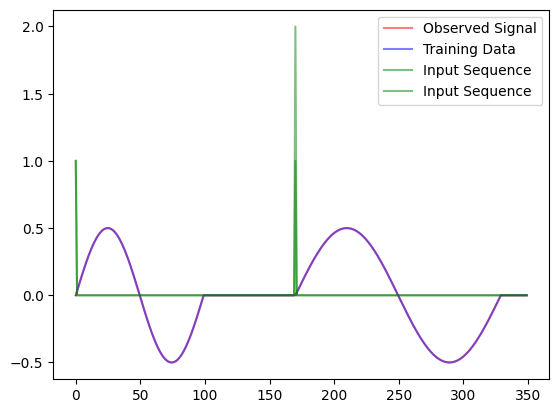

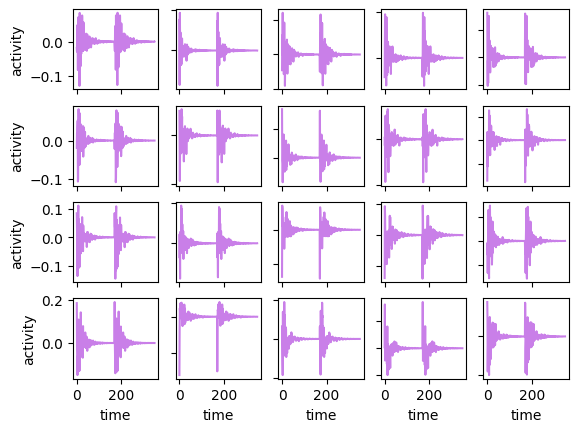

In [111]:
esn3 = ESNN(n_input=2,n_internal=2000,n_output=1,spectralRadius=5.22,inputScaling=[0.2, 0.01],noise_level=0.0, methodWeightCompute="pseudoinverse", connectivityScale=1)
esn3.train(regiment3[0],regiment3[1],0)
esn3.evaluate(regiment3[0],regiment3[1])
esn3.display_units()


In [ ]:
internal, output,input = esn2.live_run(time_points = 1000,input_type=1)




KeyboardInterrupt: 

In [109]:
print(np.mean(np.abs(esn3.W_output)))

32.234179909541155


In [37]:
print(output[0:300])

[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 3.55271368e-14]
 [ 1.57842749e-02]
 [ 3.15528157e-02]
 [ 4.72899039e-02]
 [ 6.29798525e-02]
 [ 7.86070215e-02]
 [ 9.41558332e-02]
 [ 1.09610788e-01]
 [ 1.24956481e-01]
 [ 1.40177615e-01]
 [ 1.55259016e-01]
 [ 1.70185652e-01]
 [ 1.84942643e-01]
 [ 1.99515279e-01]
 [ 2.13889034e-01]
 [ 2.28049580e-01]
 [ 2.41982801e-01]
 [ 2.55674808e-01]
 [ 2.69111953e-01]
 [ 2.82280841e-01]
 [ 2.95168346e-01]
 [ 3.07761620e-01]
 [ 3.20048111e-01]
 [ 3.32015572e-01]
 [ 3.43652071e-01]
 [ 3.54946011e-01]
 [ 3.65886133e-01]
 [ 3.76461532e-01]
 [ 3.86661666e-01]
 [ 3.96476367e-01]
 [ 4.05895851e-01]
 [ 4.14910730e-01]
 [ 4.23512017e-01]
 [ 4.31691138e-01]
 [ 4.39439939e-01]
 [ 4.46750698e-01]
 [ 4.53616125e-01]
 [ 4.60029379e-01]
 [ 4.65984065e-01]
 [ 4.71474247e-01]
 [ 4.76494455e-01]
 [ 4.81039682e-01]
 [ 4.8510539

2
3


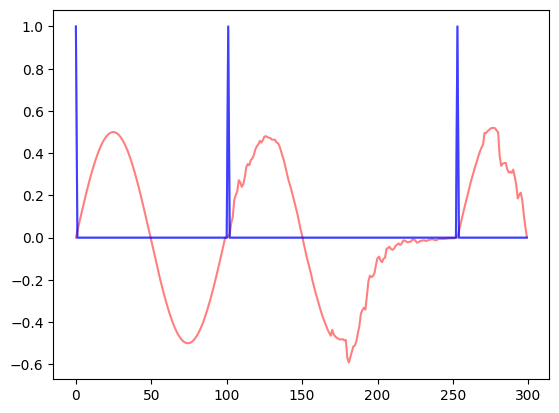

In [110]:
internal,output,input = esn3.live_run(time_points=300,input_type=2)
plt.plot(output, color="red", alpha = 0.5, label = "output")
plt.plot(input, color="blue", alpha = 0.5, label = "input")


In [103]:
print(input[0:200,:])

[[1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 

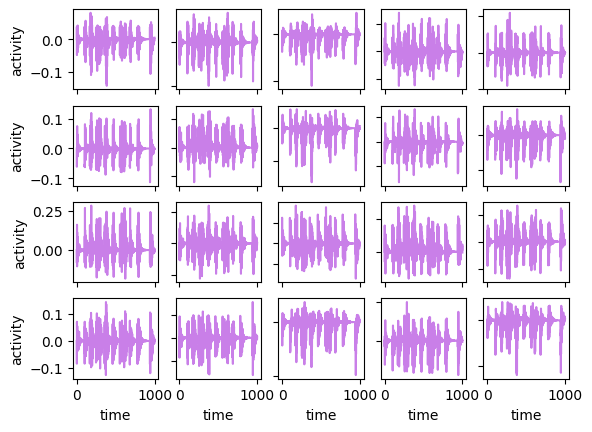

In [29]:
esn3.display_units()

mean square error= 64.49887626195327 error= 26.45728263433891
[[ 3.30557770e+09]
 [ 5.10905647e+09]
 [ 1.87255046e+09]
 ...
 [ 2.45492414e+08]
 [-7.91094913e+09]
 [-1.05927683e+10]]


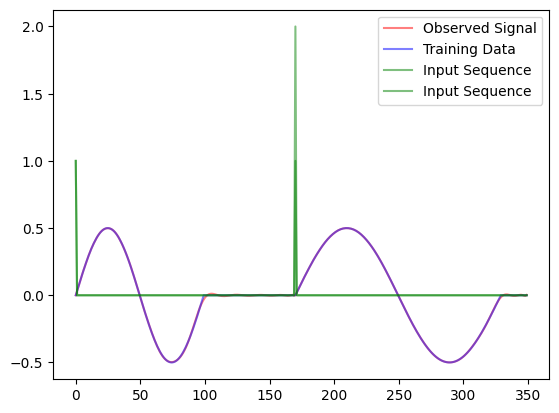

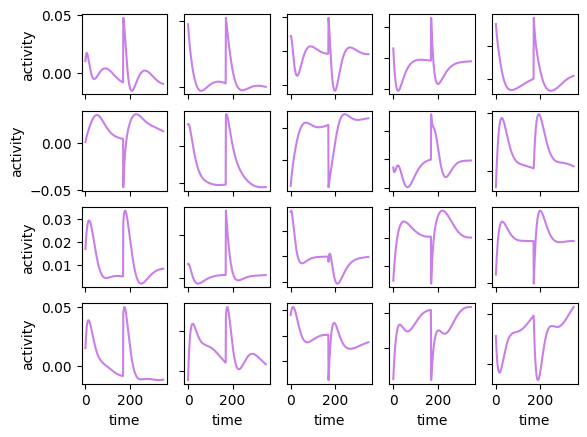

In [20]:
esn4 = ESNN(n_input=2,n_internal=4000,n_output=1,spectralRadius=3,inputScaling=1,noise_level=0.0, methodWeightCompute="pseudoinverse", connectivityScale=1, network_type ="leaky",leakage=0.6,time_constant=.1)


esn4.train(regiment3[0],regiment3[1],0)
esn4.evaluate(regiment3[0],regiment3[1])
esn4.display_units()
print(esn4.W_output)

In [50]:
time_points=350
inputSequence = np.zeros((time_points, 2))
inputSequence[1,0] = 1
#for i in np.arange(0,201,200):
#inputSequence[i,:] = 1
for i in np.arange(300,350,1):
    inputSequence[i,0] = 1  
    inputSequence[i,1]=2

print(inputSequence)

[[0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 